In [1]:
## Imports
import numpy as np
import torch
from tabulate import tabulate
import pandas as pd
import random
from PIL import Image
import heapq
import json
import tqdm
from sortedcontainers import SortedList
from torch.utils.data import DataLoader
from utils.factory import create_model_and_transforms, get_tokenizer
from utils.visualization import image_grid, visualization_preprocess
from prs_hook import hook_prs_logger
from matplotlib import pyplot as plt
from utils.imagenet_classes import imagenet_classes
from compute_complete_text_set import svd_data_approx
from utils.dataset_helpers import dataset_to_dataloader
from torchvision.datasets import ImageNet


/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
## Hyperparameters

device = 'cpu'
pretrained = 'laion2b_s34b_b79k' # 'laion2b_s32b_b79k'
model_name = 'ViT-B-32' # 'ViT-H-14'
seed = 0
dataset_text_name = "top_1500_nouns_5_sentences_imagenet_bias_clean"
datataset_image_name = "imagenet"
algorithm = "svd_data_approx"
batch_size = 16 # only needed for the nn search
imagenet_path = './datasets/imagenet/' # only needed for the nn search

In [3]:
## Loading Model

model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained)
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))

prs = hook_prs_logger(model, device, spatial=False) # This attach hook to get the residual stream

Using local files


/home/ggil/ETHZ/MTWORK2024/MT2024/utils/factory.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_location)


Model parameters: 151,277,313
Context length: 77
Vocab size: 49408
Len of res: 12


In [5]:
## Run algorithm on a dataset to derive eigenvectors 
command = f"python compute_complete_text_set.py --device {device} --model {model_name} --algorithm {algorithm} --seed {seed} --text_per_eigenvector 20 --num_of_last_layers 4 --text_descriptions {dataset_text_name}"
!{command}

/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Number of layers: 12
  0%|                                                     | 0/4 [00:00<?, ?it/s]
Layer [8], Head: 0

Layer [8], Head: 1

Layer [8], Head: 2

Layer [8], Head: 3

Layer [8], Head: 4

Layer [8], Head: 5

Layer [8], Head: 6

Layer [8], Head: 7

Layer [8], Head: 8

Layer [8], Head: 9

Layer [8], Head: 10

Layer [8], Head: 11
 25%|███████████▎                                 | 1/4 [00:02<00:07,  2.36s/it]
Layer [9], Head: 0

Layer [9], Head: 1

Layer [9], Head: 2

Layer [9], Head: 3

Layer [9], Head: 4

Layer [9], Head: 5

Layer [9], Head: 6

Layer [9], Head: 7

Layer [9], Head: 8

Layer [9], Head: 9

Layer [9], Head: 10

Layer [9], Head: 11
 50%|██████████████████████▌              

In [38]:
# Load the new created attention datasets
attention_dataset = f"output_dir/{datataset_image_name}_completeness_{dataset_text_name}_{model_name}_algo_{algorithm}_seed_{seed}.jsonl"
final_embeddings_images = torch.tensor(np.load(f"output_dir/{datataset_image_name}_embeddings_{model_name}_seed_{seed}.npy", mmap_mode="r"))
final_embeddings_texts = torch.tensor(np.load(f"output_dir/{dataset_text_name}_{model_name}.npy", mmap_mode="r"))
with open( f"text_descriptions/{dataset_text_name}.txt", "r") as f:
    texts_str = np.array([i.replace("\n", "") for i in f.readlines()])


# Print all the Eigenvectors for all the Heads

In [7]:
data = []
min_eigenvector = 5
# Print all the information we have
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)  # Parse each line as a JSON object

        # Analyze each eigenvector    
        for i, eigenvector_data in enumerate(entry["embeddings_sort"]):
            if i == min_eigenvector:
                break
            data.append({
                "layer": entry["layer"],
                "head": entry["head"],
                "eigenvector": i,
                "strength_abs": eigenvector_data["strength_abs"],
                "texts": eigenvector_data["text"],
                "rank": len(entry["embeddings_sort"])
            })
    
# Display the results
top_k_df = pd.DataFrame(data)

for row in top_k_df.itertuples():
    output_rows = []
    texts = row.texts
    half_length = len(texts) // 2
    
    # Check if the first half is positive
    is_positive_first = list(texts[0].values())[1] > 0
    
    # Split into positive and negative based on the order
    positive_texts = texts[:half_length]
    negative_texts = texts[half_length:]
    
    for pos, neg in zip(positive_texts, negative_texts):
        pos_text = list(pos.values())[0]
        pos_val  = list(pos.values())[1]
        neg_text = list(neg.values())[0]
        neg_val  = list(neg.values())[1]    
        
        output_rows.append([pos_text, pos_val, neg_text, neg_val])

    print(f"Layer {row.layer}, Head {row.head}, Eigenvector {row.eigenvector}, Strength {row.strength_abs}, Rank {row.rank}")
    # Create a DataFrame for the output
    if is_positive_first:
        columns = ["Positive", "Positive_Strength", "Negative", "Negative_Strength"]    
    else:
        columns = ["Negative", "Negative_Strength", "Positive", "Positive_Strength"]    
    output_df = pd.DataFrame(output_rows, columns=columns)

    print(tabulate(output_df, headers='keys', tablefmt='psql'))

Layer 8, Head 0, Eigenvector 0, Strength 0.4459415078163147, Rank 64
+----+-------------------------------------------------------------------+---------------------+--------------------------------------------------------------------+---------------------+
|    | Negative                                                          |   Negative_Strength | Positive                                                           |   Positive_Strength |
|----+-------------------------------------------------------------------+---------------------+--------------------------------------------------------------------+---------------------|
|  0 | An image of a vehicle with a rooftop sign.                        |           -0.139432 | An image of concentration.                                         |           0.127589  |
|  1 | An image of a majestic throne surrounded by clouds.               |           -0.138618 | An image of a complete circle.                                     |           0.1

# Strongest Contributions per Dataset

In [8]:
# Number of top entries to retrieve
top_k = 40
min_heap = []
# Read JSON lines
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)  # Parse each line as a JSON object

        if entry["head"] == -1: # Skip the last entry
            continue
        # Analyze each eigenvector    
        for i, eigenvector_data in enumerate(entry["embeddings_sort"]):
            strength_abs = eigenvector_data["strength_abs"]
            if len(min_heap) < top_k:
                heapq.heappush(min_heap, (strength_abs, i, entry))
            else:
                heapq.heappushpop(min_heap, (strength_abs, i, entry))

        
# Extract relevant details from the top k entries
top_k_entries = sorted(min_heap, key=lambda x: x[0], reverse=True)

top_k_details = [{
    "layer": entry["layer"],
    "head": entry["head"],
    "eigenvector": i,
    "strength_abs": entry["embeddings_sort"][i]["strength_abs"],
    "texts": entry["embeddings_sort"][i]["text"]
} for _, i, entry in top_k_entries]

# Display the results
top_k_df = pd.DataFrame(top_k_details)

for row in top_k_df.itertuples():
    output_rows = []
    texts = row.texts
    half_length = len(texts) // 2
    
    # Check if the first half is positive
    is_positive_first = list(texts[0].values())[1] > 0
    
    # Split into positive and negative based on the order
    positive_texts = texts[:half_length]
    negative_texts = texts[half_length:]
    
    for pos, neg in zip(positive_texts, negative_texts):
        pos_text = list(pos.values())[0]
        pos_val  = list(pos.values())[1]
        neg_text = list(neg.values())[0]
        neg_val  = list(neg.values())[1]    
        
        output_rows.append([pos_text, pos_val, neg_text, neg_val])

    print(f"Layer {row.layer}, Head {row.head}, Eigenvector {row.eigenvector}, Strength {row.strength_abs}")
    # Create a DataFrame for the output
    if is_positive_first:
        columns = ["Positive", "Positive_Strength", "Negative", "Negative_Strength"]    
    else:
        columns = ["Negative", "Negative_Strength", "Positive", "Positive_Strength"]    
    output_df = pd.DataFrame(output_rows, columns=columns)

    print(tabulate(output_df, headers='keys', tablefmt='psql'))


Layer 11, Head 7, Eigenvector 0, Strength 2.6819067001342773
+----+------------------------------------------+---------------------+---------------------------------------------+---------------------+
|    | Negative                                 |   Negative_Strength | Positive                                    |   Positive_Strength |
|----+------------------------------------------+---------------------+---------------------------------------------+---------------------|
|  0 | An image of a Tibetan Terrier.           |           -0.340224 | An image of a mayfly in mid-air.            |            0.177835 |
|  1 | An image of a mountain dog breed.        |           -0.337879 | An image of a damselfly.                    |            0.175011 |
|  2 | An image of a dog with floppy ears.      |           -0.306169 | An image of a chambered nautilus.           |            0.151028 |
|  3 | An image of a dog with shaggy fur.       |           -0.305604 | An image of a colorful arth

# Test accuracy of reconstruction using only basis

In [9]:
# Number of top entries to retrieve
top_k = 20
min_heap = []

# Prepare both text and image for the query

# Image
image = preprocess(Image.open('images/woman.png'))[np.newaxis, :, :, :]
## Run the image:
prs.reinit() # Reinitialize the residual stream hook
with torch.no_grad():
    image_emb = model.encode_image(image.to(device), 
                                        attn_method='head_no_spatial', 
                                        normalize=True)


# Text
text_query = "An image of a smiling woman."
text_query_token = tokenizer(text_query).to(device)  # tokenize
topic_emb = model.encode_text(text_query_token, normalize=True) 

# Reconstructions
image_emb_rec = torch.zeros_like(topic_emb)
topic_emb_rec = torch.zeros_like(topic_emb)
# Read JSON lines
with open(attention_dataset, "r") as json_file:
    for line in json_file:

        
        entry = json.loads(line)  # Parse each line as a JSON object
        if entry["head"] == -1:  # Skip the final embedding entry
            last_line = entry
            continue

        project_matrix = torch.tensor(entry["project_matrix"])
        vh = torch.tensor(entry["vh"])
        # Get projection of text on the head
        topic_emb_rec += (topic_emb - torch.tensor(entry["mean_values_text"])) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_text"])
        image_emb_rec += (image_emb - torch.tensor(entry["mean_values_att"])) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_att"])

print(topic_emb_rec.norm()) 
print(image_emb_rec.norm())
topic_emb_rec /= topic_emb_rec.norm(dim=-1, keepdim=True)  # normalize
image_emb_rec /= image_emb_rec.norm(dim=-1, keepdim=True)  # normalize  
print(topic_emb @ topic_emb_rec.T)
print(image_emb @ image_emb_rec.T)

print(topic_emb @ image_emb.T)
print(topic_emb @ image_emb_rec.T)
print(topic_emb_rec @ image_emb.T)
print(topic_emb_rec @ image_emb_rec.T)

tensor(37.2379, grad_fn=<LinalgVectorNormBackward0>)
tensor(10.8301)
tensor([[0.8562]], grad_fn=<MmBackward0>)
tensor([[0.8442]])
tensor([[0.3109]], grad_fn=<MmBackward0>)
tensor([[0.2223]], grad_fn=<MmBackward0>)
tensor([[0.2077]], grad_fn=<MmBackward0>)
tensor([[0.1400]], grad_fn=<MmBackward0>)


# Query a topic and NNs on that

In [10]:
# Nice examples, still need a more various dataset (i.e. this one works very well with imagenet concepts)
examples = [ "An image of the black colour palette.", # Layer 10, Head 6, Eigenvector 2  (black-yellow) or Layer 11, Head 2, Eigenvector 0,  (black-orange, white)
    "-" # Layer 11, Head 7, Eigenvector 0, the strongest eigenvector of this dataset
    "An image of seasons.", # Layer 11, Head 1, Eigenvector 4
    "An image of a whorehouse." # Layer 11, Head 9, Eigenvector 11,
    "An image of toddler.", # Layer 11, Head 2, Eigenvector 12,
    "An image of a woman." # Layer 10, Head 0, Eigenvector 0 <- This
             ] 

In [ ]:
# Number of top entries to retrieve
datas = \
{
    "layer": [],
    "head": [],
    "eigenvector": [],
    "strength_abs": []
}
top_k = 10
text_query = "An image of a bottle of water."
strength_min = 0 # Skip 
threshold_strength = 0.70

# Evaluate clip embedding for the given text
text_query_token = tokenizer(text_query).to(device)  # tokenize
topic_emb = model.encode_text(text_query_token, normalize=True)

top_entries = SortedList()
# Read JSON lines
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)  # Parse each line as a JSON object

        if entry["head"] == -1:  # Skip the final embedding entry
            continue
        # Get necessary reconstruction data
        mean_text = torch.tensor(entry["mean_values_text"])
        vh = torch.tensor(entry["vh"])
        project_matrix = torch.tensor(entry["project_matrix"])

        # Get projection of text on the head
        topic_emb_proj = (topic_emb - mean_text) @ vh.T
        # Analyze each eigenvectors 
        for i, eigenvector_data in enumerate(entry["embeddings_sort"]):

            # Get absolute strn of the eigenvector
            text_corr = topic_emb_proj[:, i].squeeze()

            # Evaluate correlatcolorsion as the maximum value
            corr_sign = text_corr > 0
            correlation_value = torch.abs(text_corr).item()
            # Retrieve the top entries score of the database (both positive and negative)
            sign_order = list(eigenvector_data["text"][0].values())[1] > 0
            v_first =  list(eigenvector_data["text"][0].values())[1]
            v_second = list(eigenvector_data["text"][len(eigenvector_data["text"])//2].values())[1]
            v_pos = v_first if sign_order else v_second
            v_neg = v_first if not sign_order else v_second
            
            # Derive a relative score
            score = torch.max((text_corr - v_pos)/np.abs(v_pos), (-text_corr + v_neg)/np.abs(v_neg)).item()
            # Discard too low coorelation
            if eigenvector_data["strength_abs"]*correlation_value < strength_min or \
            (text_corr/v_pos < threshold_strength if corr_sign else text_corr/v_neg <  threshold_strength):
                continue
            top_entries.add((score, (i, corr_sign, eigenvector_data["strength_abs"]*correlation_value, entry)))

            if len(top_entries) > top_k:
                top_entries.pop(0)  # Remove the smallest correlation

# Extract relevant details from the top k entries
top_k_entries = list(top_entries)[::-1]  # Reverse to have largest first
top_k_details = []
for (score, (i, corr_sign, correlation, entry)) in top_k_entries:
    texts = entry["embeddings_sort"][i]["text"]
    length = len(texts) // 2
    first_text_pos = (list(entry["embeddings_sort"][i]["text"][0].values())[1] > 0)
    # Sort texts based on the correlation sign
    texts = sorted(texts[:length], key=lambda x: list(x.values())[1], reverse= first_text_pos) + \
            sorted(texts[length:], key=lambda x: list(x.values())[1], reverse= not first_text_pos)

        
    top_k_details.append({
        "layer": entry["layer"],
        "head": entry["head"],
        "eigenvector": i,
        "eigenvector_strength": entry["embeddings_sort"][i]["strength_abs"],
        "correlation": correlation/entry["embeddings_sort"][i]["strength_abs"] if corr_sign else -correlation/entry["embeddings_sort"][i]["strength_abs"],
        "strength": correlation if corr_sign else -correlation,
        "texts": texts
    })

top_k_df = pd.DataFrame(top_k_details)
# Display the results
for row in top_k_df.itertuples():
    output_rows = []
    # Show the correlation of each eigenvector already multiplied by the strength of the right singular value
    texts = [{k: (v * row.eigenvector_strength if i == 1 else v) for i, (k, v) in enumerate(d.items())} for d in row.texts]
    half_length = len(texts) // 2
    # Check if the first half is positive
    is_positive_corr = row.correlation > 0
    is_positive_first = list(texts[0].values())[1] > 0

    # Create a DataFrame for the output
    if is_positive_corr:
        columns = ["Positive", "Positive_Strength", "Negative", "Negative_Strength"] 
        first = texts[:half_length] if is_positive_first else texts[half_length:]
        second = texts[half_length:] if is_positive_first else texts[:half_length] 
    else:
        columns = ["Negative", "Negative_Strength", "Positive", "Positive_Strength"]   
        first = texts[half_length:] if is_positive_first else texts[:half_length]
        second = texts[:half_length] if is_positive_first else texts[half_length:]
        
    for pos, neg in zip(first, second):
        pos_text = list(pos.values())[0]
        pos_val  = list(pos.values())[1]
        neg_text = list(neg.values())[0]
        neg_val  = list(neg.values())[1]    
        
        output_rows.append([pos_text, pos_val, neg_text, neg_val])

    # Append the information to datas
    datas["layer"].append(row.layer)
    datas["head"].append(row.head)
    datas["eigenvector"].append(row.eigenvector)
    datas["strength_abs"].append(row.strength)
    print(f"Layer {row.layer}, Head {row.head}, Eigenvector {row.eigenvector}, Eigenvector Strength {row.eigenvector_strength}, Correlation {row.correlation}, Strength {row.strength}")    
     
    output_df = pd.DataFrame(output_rows, columns=columns)


    print(tabulate(output_df, headers='keys', tablefmt='psql'))


In [173]:
# Where we want to project at
datas = datas
""" {
    "layer": [11],
    "head": [9],
    "eigenvector": [21],
    "strength_abs": [0.180821]
} """
len_datas = len(datas["layer"])
# Combine all fields, sort them, and unpack back into lists
sorted_combined = sorted(
    zip(datas["layer"], datas["head"], datas["eigenvector"], datas["strength_abs"])
)

datas["layer"], datas["head"], datas["eigenvector"], datas["strength_abs"] = map(
    list, zip(*sorted_combined)
)
print(len_datas)

# Optional text to find value at some strength in the eigenvector
text_pres = True
text_query = text_query
text_query_token = tokenizer(text_query).to(device)  # tokenize
text_emb = model.encode_text(text_query_token, normalize=True) 

10


In [174]:
## Create the pool for the nn search from same dataset
ds = ImageNet(root=imagenet_path, split="val", transform=preprocess) # For running the model
ds_vis = ImageNet(root=imagenet_path, split="val", transform=visualization_preprocess) # For showing images

# Take subset of dataset
samples_per_class=1
tot_samples_per_class=50
random.seed(seed)
all_indices = list(range(len(ds)))
nr_classes = len(ds.classes)
index = [random.sample(all_indices[x*tot_samples_per_class:(x + 1)*tot_samples_per_class], samples_per_class) for x in range(nr_classes)]
index = [x for xs in index for x in xs]
dataset = torch.utils.data.Subset(ds, index)
ds_vis = torch.utils.data.Subset(ds_vis, index)

# Get wanted vh matrix
vh = []
mean_values_att = []
mean_values_text = []
eigenvector_strength = []
entries = []
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)  # Parse each line as a JSON object

        # Keep looking until right head and layer is found
        if (entry["layer"], entry["head"]) not in zip(datas["layer"], datas["head"]):
            continue
        
        # Get vh matrix from 
        for (layer, head, eigenvector) in zip(datas["layer"], datas["head"], datas["eigenvector"]):
            if (layer, head) == (entry["layer"], entry["head"]):
                vh.append(torch.tensor(entry["vh"]))
                mean_values_att.append(torch.tensor(entry["mean_values_att"]))
                mean_values_text.append(torch.tensor(entry["mean_values_text"]))
                eigenvector_strength.append(entry["embeddings_sort"][eigenvector]["strength_abs"])
                entries.append(entry)

with torch.no_grad():
    for i in range(len_datas):
        mask = torch.zeros((vh[i].shape[0]))
        mask[datas["eigenvector"][i]] = datas["strength_abs"][i]
        if i == 0:
            query_repres = mask @ vh[i]
        else:
            query_repres += mask @ vh[i]


### Optional

In [175]:
# Preprocess dataset to already have all images

### Test on images and texts

In [176]:
# Initialize array store the top and worst scores for each search head
scores_array_images = np.empty(final_embeddings_images.shape[0], dtype=[('score', 'f4'), ('img_index', 'i4')])
scores_array_texts = np.empty(final_embeddings_texts.shape[0], dtype=[('score', 'f4'), ('txt_index', 'i4')])

indexes_images = np.arange(0, final_embeddings_images.shape[0], 1) 
indexes_texts = np.arange(0, final_embeddings_texts.shape[0], 1) 

# Go over the dataset and calculate scores for each search head
# Iterate over all vh
for i in range(len_datas):
    projection_images =  eigenvector_strength[i]*((final_embeddings_images - mean_values_att[i]) @ vh[i].T)
    mask_images = torch.zeros_like(projection_images)
    mask_images[:, datas["eigenvector"][i]] = projection_images[:, datas["eigenvector"][i]]
    
    projection_texts =  eigenvector_strength[i]*((final_embeddings_texts - mean_values_text[i]) @ vh[i].T)
    mask_texts = torch.zeros_like(projection_texts)
    mask_texts[:, datas["eigenvector"][i]] = projection_texts[:, datas["eigenvector"][i]]
    if i == 0:
        # Project to right values space and score contribution for fixed eigenvector
        scores_images = mask_images @ vh[i]
        scores_texts = mask_texts @ vh[i]
    else:
        scores_images += mask_images @ vh[i]
        scores_texts += mask_texts @ vh[i]  

# Update top and worst scores for the current search head
scores_array_images["score"] = (scores_images @ query_repres.T).numpy()
scores_array_images["img_index"] = indexes_images
scores_array_texts["score"] = (scores_texts @ query_repres.T).numpy()
scores_array_texts["txt_index"] = indexes_texts

In [177]:
# Define the number of top and worst images to look at for each eigenvector
nr_top_imgs = 20  # Number of top elements
nr_worst_imgs = 20  # Number of worst elements
nr_cont_imgs = 20  # Length of continuous elements
nr_text_imgs = 20  # Length of most similar images

# Sort indices of scores
sorted_scores_images = np.sort(scores_array_images, order='score')
sorted_scores_texts = np.sort(scores_array_texts, order='score')

# Top scores
top_dbs_images = sorted_scores_images[-nr_top_imgs:][::-1]  # Get top `nr_top_imgs` elements, sorted descending
top_dbs_texts = sorted_scores_texts[-nr_top_imgs:][::-1]  # Get top `nr_top_imgs` elements, sorted descending

# Worst scores
worst_dbs_images = sorted_scores_images[:nr_worst_imgs]  # Get worst `nr_worst_imgs` elements, sorted ascending
worst_dbs_texts = sorted_scores_texts[:nr_worst_imgs]  # Get worst `nr_worst_imgs` elements, sorted ascending
# Continuous scores (step-based interpolation)
t = np.linspace(0, 1, num=nr_cont_imgs)  # Uniformly spaced in [0, 1]
scaled_t = 0.5 * (1 - np.cos(np.pi * t))  # Cosine transformation for symmetry
nonlinear_indices_images = (scaled_t * (len(sorted_scores_images) - 1)).astype(int)
cont_dbs_images = sorted_scores_images[nonlinear_indices_images]
nonline_indices_texts = (scaled_t * (len(sorted_scores_texts) - 1)).astype(int)
cont_dbs_texts = sorted_scores_texts[nonline_indices_texts]

In [178]:
def image_grid(images, rows, cols, labels=None, scores=None, figsize=None):
    """Displays images in a grid with optional labels and scores."""
    if figsize is None:
        # Dynamically calculate figure size if not provided
        figsize = (cols * 2, rows * 2)  # Adjust scaling factor as needed
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            title = ''
            if labels:
                title += labels[i]
            if scores:
                title += f" ({scores[i]:.4f})"
            ax.set_title(title, fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

----Decomposition for text: 'An image of a wonderful party.'----
Layer 8, Head 1, Eigenvector 13, Strength -0.005828753575387813
+----+-----------------------------------------------------------------+---------------------+-----------------------------------------------------------------------+---------------------+
|    | Negative                                                        |   Negative_Strength | Positive                                                              |   Positive_Strength |
|----+-----------------------------------------------------------------+---------------------+-----------------------------------------------------------------------+---------------------|
|  0 | An image of ears and listening.                                 |          -0.0957918 | An image of a television mounted on a wall.                           |           0.119134  |
|  1 | An image of planes parked at gates.                             |          -0.0953428 | An image of a person

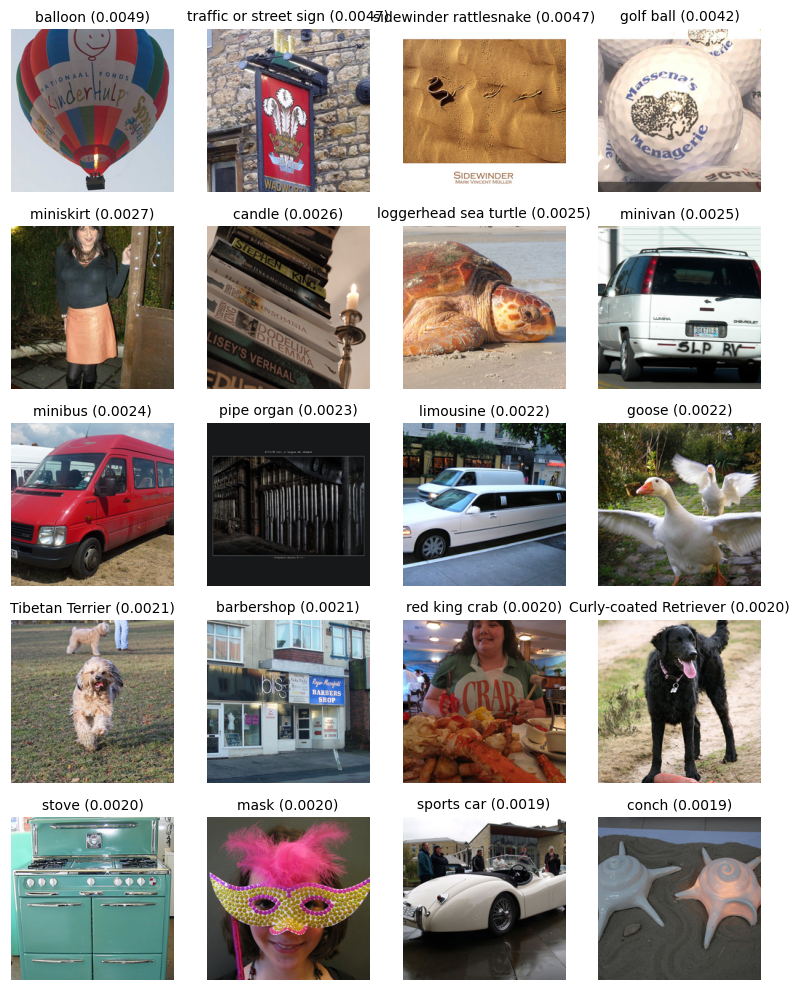

Printing most negative correlation for text: 'An image of a wonderful party. with strength 0.005197754595428705'
+----+------------------------------------------------------------+-------------+
|    | Text                                                       |    Strength |
|----+------------------------------------------------------------+-------------|
|  0 | An image of an estimation process.                         | -0.00458973 |
|  1 | An image of something ordinary.                            | -0.00455367 |
|  2 | An image of efficiency.                                    | -0.00454605 |
|  3 | An image of something broad.                               | -0.00443937 |
|  4 | An image of the word 'theory' written on a piece of paper. | -0.00438498 |
|  5 | An image of mode settings displayed on a screen.           | -0.00432485 |
|  6 | An image of something temporary.                           | -0.00423231 |
|  7 | An image of a protest sign reading “climate hoax.”         |

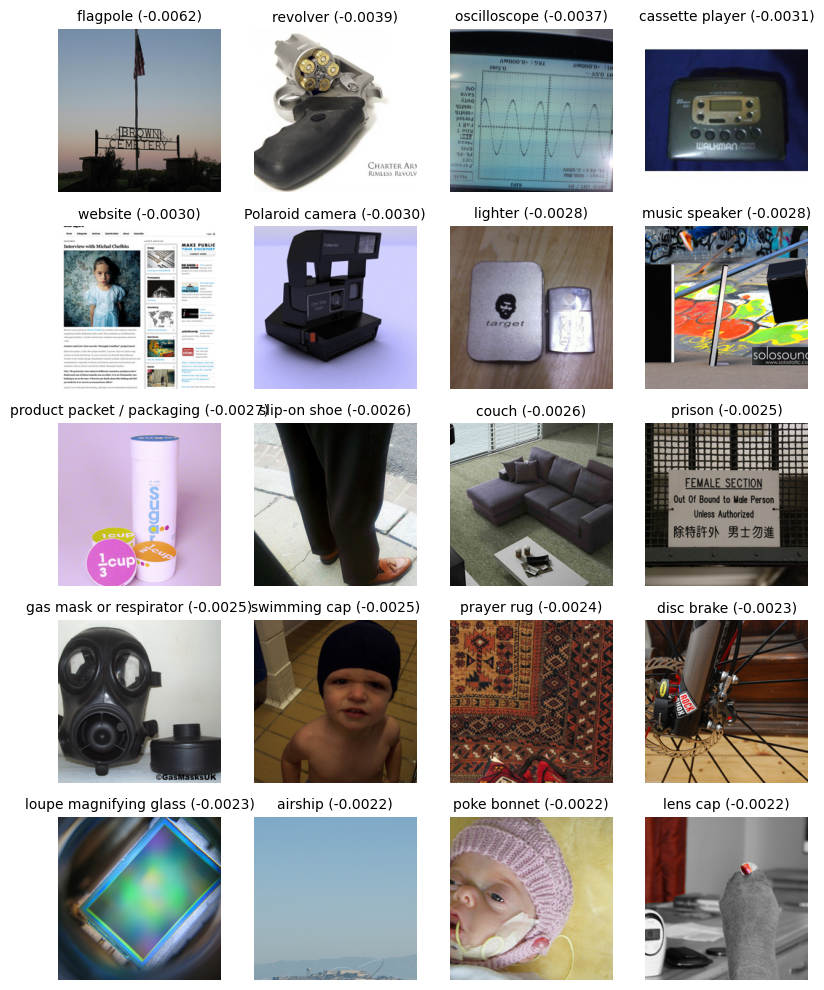

Printing continous correlation for text: 'An image of a wonderful party. with strength 0.005197754595428705'
+----+--------------------------------------------------------------------------------+--------------+
|    | Text                                                                           |     Strength |
|----+--------------------------------------------------------------------------------+--------------|
|  0 | An image of an estimation process.                                             | -0.00458973  |
|  1 | An image of a person surrounded by multiple stimuli but fixated on one object. | -0.00291237  |
|  2 | An image of interlocking puzzle pieces.                                        | -0.00219593  |
|  3 | An image of a thermometer displaying temperature.                              | -0.00173331  |
|  4 | An image of data points plotted on a graph.                                    | -0.0013834   |
|  5 | An image of a small boat.                                   

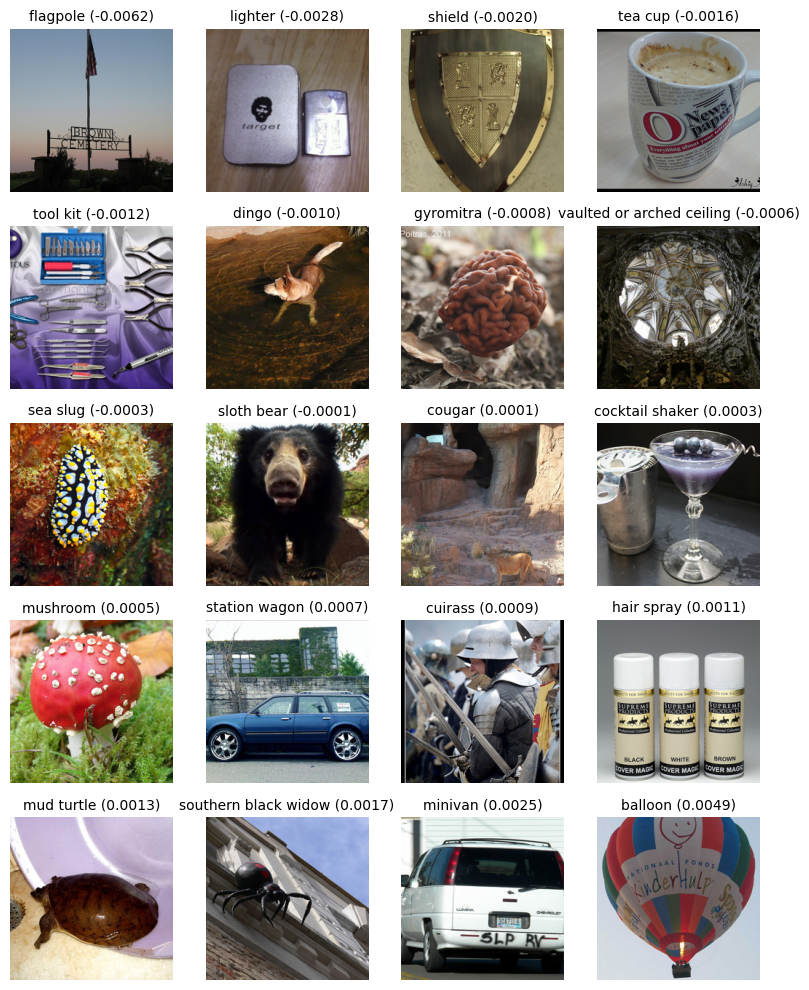

In [179]:
print(f"----Decomposition for text: '{text_query}'----")
# Print info eigenvectors
for i in range(len_datas):
    output_rows = []
    texts = entries[i]["embeddings_sort"][datas["eigenvector"][i]]["text"]
    half_length = len(texts) // 2

    # Check if the first half is positive
    is_positive_first = list(texts[0].values())[1] > 0
    want_positive_first = datas["strength_abs"][i] > 0
    # Split into positive and negative based on the order
    if is_positive_first == want_positive_first:
        positive_texts = texts[:half_length]
        negative_texts = texts[half_length:]
    else:
        positive_texts = texts[half_length:]
        negative_texts = texts[:half_length]

    for pos, neg in zip(positive_texts, negative_texts):
        pos_text = list(pos.values())[0]
        pos_val  = list(pos.values())[1]
        neg_text = list(neg.values())[0]
        neg_val  = list(neg.values())[1]    
        
        output_rows.append([pos_text, pos_val, neg_text, neg_val])

    print(f"Layer {datas["layer"][i]}, Head {datas["head"][i]}, Eigenvector {datas["eigenvector"][i]}, Strength {datas["strength_abs"][i]}")
    # Create a DataFrame for the output
    if want_positive_first:
        columns = ["Positive", "Positive_Strength", "Negative", "Negative_Strength"]    
    else:
        columns = ["Negative", "Negative_Strength", "Positive", "Positive_Strength"]    
    output_df = pd.DataFrame(output_rows, columns=columns)

    print(tabulate(output_df, headers='keys', tablefmt='psql'))

indexes = np.array([idx for score, idx in top_dbs_texts])



# Show images
strength = query_repres @ query_repres.T
dbs = [(top_dbs_images, top_dbs_texts, f"Printing most positive correlation for text: '{text_query} with strength {strength}'", nr_top_imgs), \
       (worst_dbs_images, worst_dbs_texts, f"Printing most negative correlation for text: '{text_query} with strength {strength}'", nr_worst_imgs), \
       (cont_dbs_images, cont_dbs_texts, f"Printing continous correlation for text: '{text_query} with strength {strength}'", nr_cont_imgs)]

for db, db_text, text, length in dbs:
    images, labels, scores = [], [], []
    for score, image_index in db:
        images.append(ds_vis[image_index][0])
        labels.append(imagenet_classes[ds_vis[image_index][1]])
        scores.append(score)
    print(text)
    # Print text
    output_rows = []
    for score, text_index in db_text:
        output_rows.append([texts_str[text_index], score])
    output_df = pd.DataFrame(output_rows, columns=["Text", "Strength"])
    print(tabulate(output_df, headers='keys', tablefmt='psql'))
    # Print images
    rows, cols = (length // 4, 4)  # Or dynamically calculate rows and cols
    image_grid(images, rows, cols, labels=labels, scores=scores)
    

